In [91]:
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import ElasticNetCV, LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y
from sklearn.utils.validation import _check_sample_weight
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
from collections import defaultdict
import dvu
import pandas as pd
import matplotlib.pyplot as plt
import json
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
import joblib
import viz

import imodels
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor

from sklearn.base import RegressorMixin, ClassifierMixin
from imodels.algebraic.gam_multitask import MultiTaskGAMRegressor

In [87]:
# dset = 'bike_sharing'
# dset = 'california_housing'
# dset = 'diabetes_regr'
dset = 'heart'
X, y, feature_names = imodels.get_clean_dataset(dset)
X, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

kwargs = dict(
    random_state=42,
)
results = defaultdict(list)
gam = MultiTaskGAMRegressor(multitask=True, interactions=False)

fetching heart from imodels


In [88]:
np.random.seed(42)
gam.fit(X, y_train)
print('test_corr', np.corrcoef(
    y_test, gam.predict(X_test))[0, 1].round(3))
print('test r2', gam.score(X_test, y_test).round(3))
joblib.dump(gam, f'../figs/{dset}_gam.pkl')

100%|██████████| 15/15 [01:10<00:00,  4.69s/it]


test_corr 0.692
test r2 0.472


['../figs/heart_gam.pkl']

In [89]:
gam = joblib.load(f'../figs/{dset}_gam.pkl')

# Visualize the model

/home/chansingh/data-viz-utils/dvu/dvu.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_3258027/329039638.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


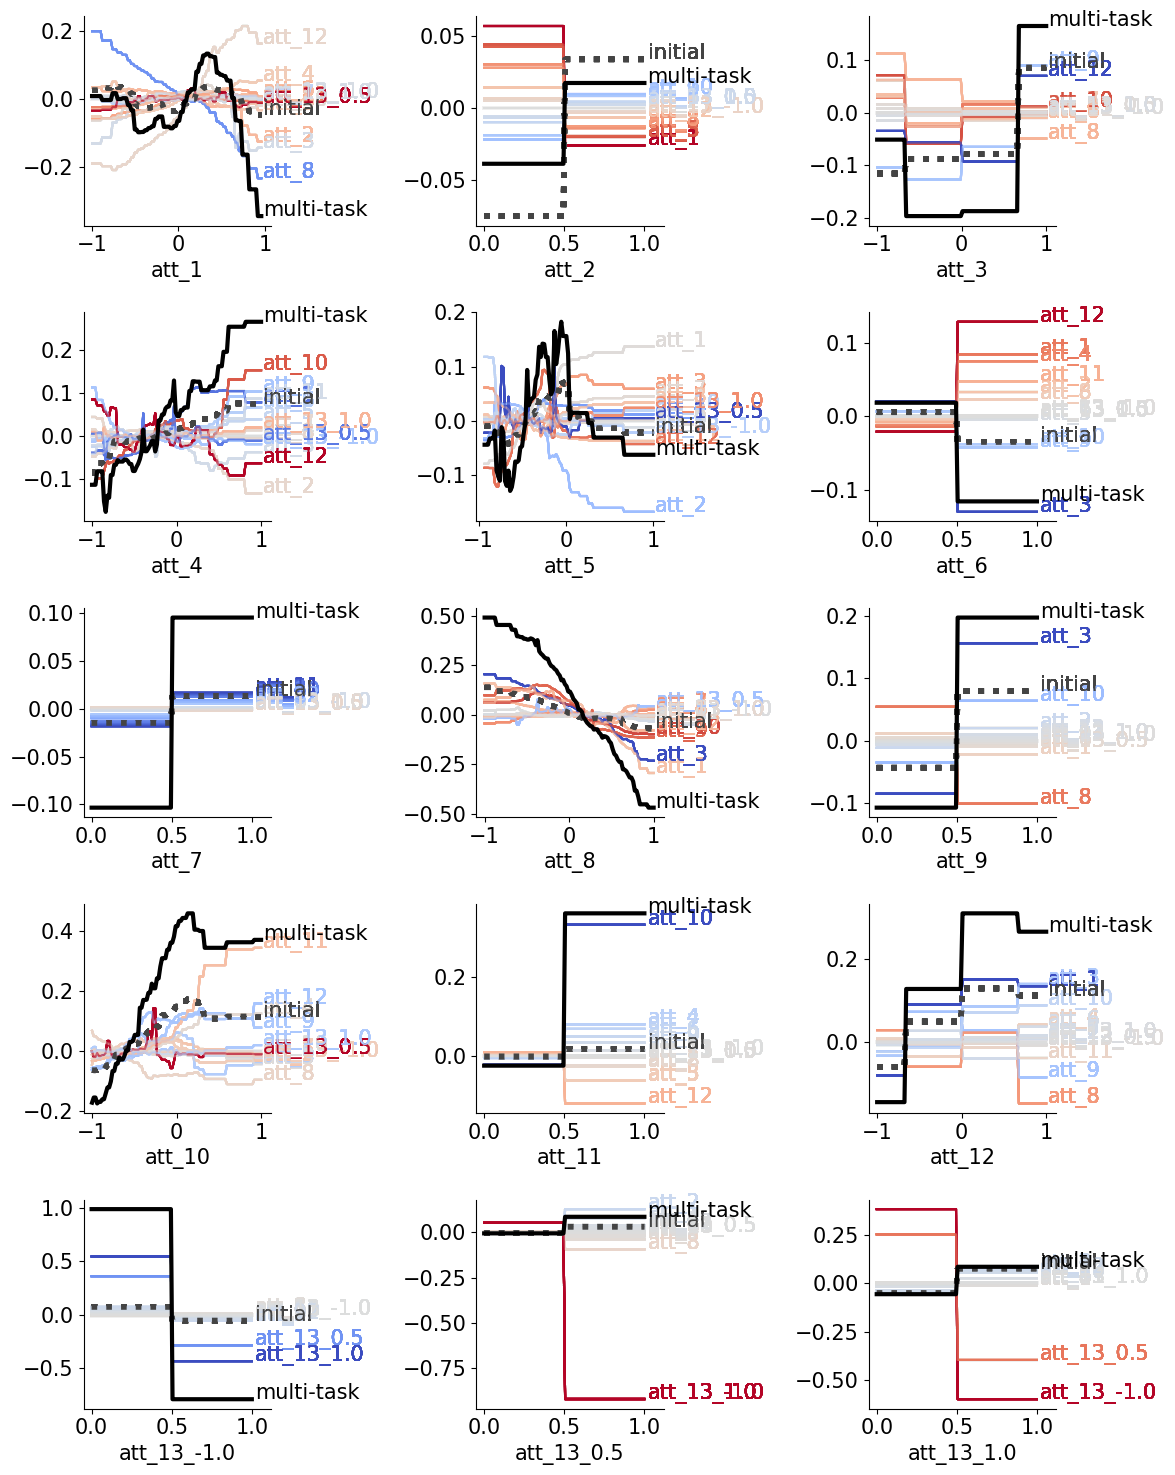

In [90]:
# generate linspace curves for each feature and show EBM evals of all of them
mins = X.min(axis=0)
maxes = X.max(axis=0)
n = 100
linspaces = [np.linspace(mins[i], maxes[i], n) for i in range(X.shape[1])]
linspaces = np.array(linspaces).T
evals = gam._extract_ebm_features(linspaces)
num_ebms = len(gam.ebms_)
num_features = X.shape[1]

C = 3
R = int(np.ceil(num_features / C))
plt.figure(figsize=(C * 4,  R * 3))
# grid = plt.GridSpec(R, C, hspace=0.4)
for feat_num in range(num_features):
    # r = feat_num // C
    # c = feat_num % C
    # plt.subplot(grid[r, c])
    plt.subplot(R, C, feat_num + 1)
    for ebm_num in range(num_ebms):

        idxs_feat_num = np.arange(
            feat_num, num_ebms * num_features, num_features)
        coefs = gam.lin_model.coef_[idxs_feat_num]

        # get diverging colormap based on coefs
        colors = viz._get_diverging_colors_centered_at_zero(coefs[:-1])

        for feat_name_predicting, idx in enumerate(idxs_feat_num[:-1]):
            plt.plot(linspaces[:, feat_num],
                     evals[:, idx],
                     alpha=0.5,
                     label=str(feature_names[feat_name_predicting]),
                     color=colors[feat_name_predicting])
        plt.plot(linspaces[:, feat_num],
                 evals[:, idxs_feat_num[-1]], color='#444', linestyle=':', label='initial', lw=4)

    plt.plot(linspaces[:, feat_num], np.dot(
        evals[:, idxs_feat_num], coefs), color='black', lw=3, label='multi-task')
    plt.xlabel(feature_names[feat_num])

    dvu.line_legend()
plt.tight_layout()
plt.savefig(f'../figs/gam_curves/{dset}.pdf', bbox_inches='tight')
plt.show()